## 1. Business Understanding

The opioid epidemic continues to pose a serious public health challenge in the United States. EMS agencies are often the first point of contact in opioid-related emergencies, making their data a rich source of insight.

**Goal**: Use EMS data to identify patterns and predictors associated with opioid overdose cases and their outcomes (e.g., field ROSC, transport decisions, ED disposition).

**Stakeholders**: EMS agency leadership, public health officials, policymakers, clinical educators.

**Key Questions**:
- What are the characteristics of opioid overdose patients treated by EMS?
- What factors are associated with improved outcomes (e.g., ROSC, transport to higher-level facilities)?
- How can this data support triage, resource deployment, or public health intervention?

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    make_scorer,
    recall_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier

import shap

# Data Understanding

Observations:

65 columns have some missing values.

Some vitals like BGL_std, ETCO2_std, GCS_*_std, etc., have >40–90% missing, which may make them candidates for removal or separate handling.

Core fields like naloxone_administered, resuscitation_flag, etc. have no missing values and are fully populated (possibly due to filtering).

In [135]:
# Load and clean the merged dataset
df = pd.read_csv("../data/interim/opioid_cases_full.csv", low_memory=False)

# Strip tildes and spaces from all object columns
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip(" ~")

print("Data loaded and string columns cleaned. Shape:", df.shape)

Data loaded and string columns cleaned. Shape: (297762, 98)


In [136]:
# Display the first few rows
df.head()

,PcrKey,eDispatch_01,eDispatch_02,eArrest_14,eArrest_01,eArrest_02,eArrest_05,eArrest_07,eArrest_11,eArrest_16,...,protocols_used,protocol_count,arrest_witnessed_flag,resuscitation_flag,cpr_provided_flag,rosc_flag,dest_rhythm_count,race_count,eResponse_24,eDisposition_18
0,225614082,2301053,7701003,Not Applicable,3001001,7701001,7701001,7701001,7701001,7701001,...,9914075,1,1,1,1,1,1,1,2224015,7701001
1,225614423,2301053,2302007,Not Applicable,3001001,7701001,7701001,7701001,7701001,7701001,...,9914135,1,1,1,1,1,1,1,2224015,4218011
2,225614880,2301079,2302001,Not Applicable,3001001,7701001,7701001,7701001,7701001,7701001,...,9914135,1,1,1,1,1,1,1,2224015,4218011
3,225615710,2301051,2302007,Not Applicable,3001001,7701001,7701001,7701001,7701001,7701001,...,9914113,1,1,1,1,1,1,1,2224015,4218015
4,225616308,2301053,7701003,Not Applicable,3001001,7701001,7701001,7701001,7701001,7701001,...,9914219,1,1,1,1,1,1,1,2224015,7701001


In [137]:
# Display outcome code distribution
df['eOutcome_01'].value_counts(dropna=False).sort_values(ascending=False)

eOutcome_01
7701003    247485
7701001     44600
01           2240
30           1450
09            955
07            315
02            288
65            166
21             88
70             49
20             46
03             22
04             22
66             12
05              8
06              8
62              6
63              1
61              1
Name: count, dtype: int64

In [138]:
# Filter out invalid / unrecorded outcomes
valid_outcomes = df[~df['eOutcome_01'].isin(['7701003', '7701001'])].copy()

# Map codes to official descriptions
outcome_mapping = {
    '01': 'Discharged to home or self care',
    '02': 'Transferred to short-term hospital',
    '03': 'Transferred to skilled nursing facility (SNF)',
    '04': 'Transferred to intermediate care facility (ICF)',
    '05': 'Transferred to other institution',
    '06': 'Home with home health care',
    '07': 'Left against medical advice (AMA)',
    '09': 'Admitted as inpatient',
    '20': 'Deceased / Expired',
    '21': 'Transferred to law enforcement',
    '30': 'Still a patient / outpatient return',
    '43': 'Transferred to federal facility (VA etc.)',
    '50': 'Hospice - home',
    '51': 'Hospice - medical facility',
    '61': 'Transferred within institution (swing bed)',
    '62': 'Transferred to inpatient rehab',
    '63': 'Transferred to long-term care hospital',
    '64': 'Transferred to Medicaid-only nursing facility',
    '65': 'Transferred to psychiatric facility',
    '66': 'Transferred to Critical Access Hospital (CAH)',
    '70': 'Transferred to other healthcare institution',
}

valid_outcomes['eOutcome_01_label'] = valid_outcomes['eOutcome_01'].map(outcome_mapping)

print("Data filtered to only include events with hospital outcomes recorded. Shape:", valid_outcomes.shape)

Data filtered to only include events with hospital outcomes recorded. Shape: (5677, 99)


In [139]:
# Check summary stats for sanity
valid_outcomes[num_cols].describe()

,heart_rate,resp_rate,systolic_bp,spo2,bgl,etco2
count,5677,5677,5677,5677,5677,5677
unique,170,71,168,93,339,98
top,7701003,7701003,7701003,7701003,7701003,7701003
freq,718,1024,1499,920,2778,3434


In [140]:
# Check current dtypes

num_cols = ['heart_rate', 'resp_rate', 'systolic_bp', 'spo2', 'bgl', 'etco2']

valid_outcomes[num_cols].dtypes

heart_rate     object
resp_rate      object
systolic_bp    object
spo2           object
bgl            object
etco2          object
dtype: object

In [141]:
# Convert vitals to numeric (suppress errors, coerce invalid values to NaN)
for col in num_cols:
    valid_outcomes[col] = pd.to_numeric(valid_outcomes[col], errors='coerce')

In [142]:
# Confirm conversion worked
valid_outcomes[num_cols].dtypes

heart_rate     float64
resp_rate      float64
systolic_bp    float64
spo2           float64
bgl            float64
etco2          float64
dtype: object

In [143]:
for col in num_cols:
    print(f"\n{col}:")
    print(valid_outcomes[col].dropna().unique()[:10])
    print("Non-numeric examples:")
    print(valid_outcomes[~valid_outcomes[col].apply(lambda x: pd.api.types.is_number(x))][col].unique())


heart_rate:
[1.400000e+02 7.701003e+06 8.000000e+01 5.200000e+01 1.100000e+02
 8.300000e+01 1.020000e+02 8.600000e+01 1.110000e+02 1.230000e+02]
Non-numeric examples:
[]

resp_rate:
[1.800000e+01 8.000000e+00 2.000000e+01 6.000000e+00 2.800000e+01
 1.600000e+01 2.400000e+01 1.400000e+01 7.701003e+06 9.000000e+00]
Non-numeric examples:
[]

systolic_bp:
[1.420000e+02 7.701003e+06 1.300000e+02 9.000000e+01 8.900000e+01
 1.430000e+02 1.340000e+02 1.120000e+02 1.200000e+02 1.630000e+02]
Non-numeric examples:
[]

spo2:
[9.500000e+01 7.701003e+06 9.900000e+01 9.700000e+01 9.800000e+01
 7.600000e+01 1.000000e+02 7.701001e+06 9.600000e+01 6.000000e+01]
Non-numeric examples:
[]

bgl:
[1.740000e+02 1.470000e+02 1.240000e+02 7.701003e+06 1.010000e+02
 1.460000e+02 1.620000e+02 1.350000e+02 1.790000e+02 7.701001e+06]
Non-numeric examples:
[]

etco2:
[7.701003e+06 1.900000e+01 3.400000e+01 3.800000e+01 3.900000e+01
 4.700000e+01 7.701001e+06 2.900000e+01 3.100000e+01 8.200000e+01]
Non-numeric examp

In [144]:
# Anything >10,000 is garbage for vitals — treat as invalid
for col in num_cols:
    valid_outcomes[col] = pd.to_numeric(valid_outcomes[col], errors='coerce')  # ensure numeric
    valid_outcomes.loc[valid_outcomes[col] > 10000, col] = np.nan              # kill outliers

In [145]:
# Check summary stats for sanity
valid_outcomes[num_cols].describe()

,heart_rate,resp_rate,systolic_bp,spo2,bgl,etco2
count,4828.000000,4526.000000,3858.000000,4199.000000,1997.000000,1233.000000
mean,98.516363,16.466637,136.232245,93.066921,162.832248,36.502028
std,27.743191,9.574003,27.490550,12.092369,87.346816,21.508648
min,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000
25%,83.000000,12.000000,119.000000,94.000000,109.000000,24.000000
50%,100.000000,16.000000,136.000000,97.000000,135.000000,38.000000
75%,115.000000,19.000000,152.000000,99.000000,190.000000,48.000000
max,238.000000,188.000000,260.000000,100.000000,600.000000,104.000000


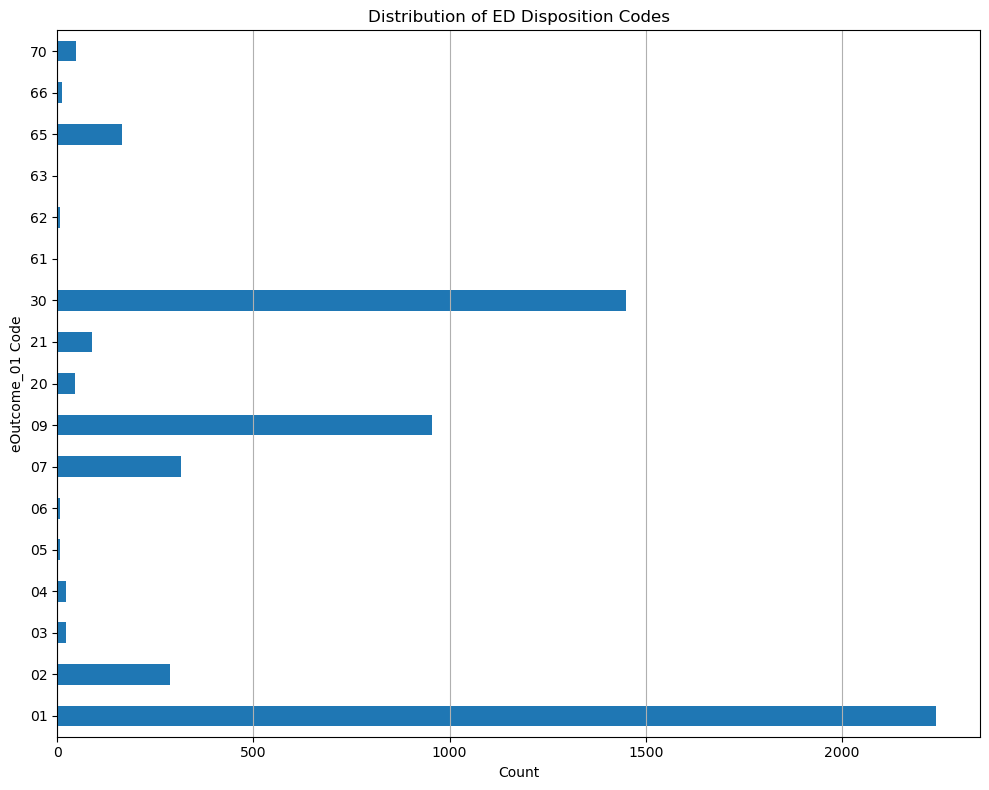

In [146]:
# Distribution of ED outcome codes (after filtering)
valid_outcomes['eOutcome_01'].value_counts().sort_index().plot(kind='barh', figsize=(10, 8))
plt.title('Distribution of ED Disposition Codes')
plt.xlabel('Count')
plt.ylabel('eOutcome_01 Code')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [147]:
# Display human-readable value counts
valid_outcomes['eOutcome_01_label'].value_counts().sort_values(ascending=False)

eOutcome_01_label
Discharged to home or self care                    2240
Still a patient / outpatient return                1450
Admitted as inpatient                               955
Left against medical advice (AMA)                   315
Transferred to short-term hospital                  288
Transferred to psychiatric facility                 166
Transferred to law enforcement                       88
Transferred to other healthcare institution          49
Deceased / Expired                                   46
Transferred to skilled nursing facility (SNF)        22
Transferred to intermediate care facility (ICF)      22
Transferred to Critical Access Hospital (CAH)        12
Transferred to other institution                      8
Home with home health care                            8
Transferred to inpatient rehab                        6
Transferred to long-term care hospital                1
Transferred within institution (swing bed)            1
Name: count, dtype: int64

In [148]:
# Basic structure
valid_outcomes.shape
valid_outcomes.info()
valid_outcomes.describe(include='all')  # include object columns too

<class 'pandas.core.frame.DataFrame'>
Index: 5677 entries, 99 to 297622
Data columns (total 99 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PcrKey                 5677 non-null   int64  
 1   eDispatch_01           5677 non-null   object 
 2   eDispatch_02           5677 non-null   object 
 3   eArrest_14             5677 non-null   object 
 4   eArrest_01             5677 non-null   object 
 5   eArrest_02             5677 non-null   object 
 6   eArrest_05             5677 non-null   object 
 7   eArrest_07             5677 non-null   object 
 8   eArrest_11             5677 non-null   object 
 9   eArrest_16             5677 non-null   object 
 10  eArrest_18             5677 non-null   object 
 11  eDisposition_12        5677 non-null   object 
 12  eDisposition_19        5677 non-null   object 
 13  eDisposition_16        5677 non-null   object 
 14  eDisposition_21        5677 non-null   object 
 15  eDispo

,PcrKey,eDispatch_01,eDispatch_02,eArrest_14,eArrest_01,eArrest_02,eArrest_05,eArrest_07,eArrest_11,eArrest_16,...,protocol_count,arrest_witnessed_flag,resuscitation_flag,cpr_provided_flag,rosc_flag,dest_rhythm_count,race_count,eResponse_24,eDisposition_18,eOutcome_01_label
count,5.677000e+03,5677,5677,5677,5677,5677,5677,5677,5677,5677,...,5677.000000,5677.0,5677.0,5677.0,5677.0,5677.000000,5677.000000,5.677000e+03,5.677000e+03,5677
unique,NaN,32,6,93,5,6,5,5,8,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
top,NaN,2301053,7701003,Not Recorded,3001001,7701003,7701003,7701003,7701003,7701003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Discharged to home or self care
freq,NaN,2084,2534,4647,5071,4641,3394,4645,4658,4665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2240
mean,2.556990e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.083671,1.0,1.0,1.0,1.0,1.001233,1.011450,3.882451e+06,5.014982e+06,NaN
std,1.703396e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.348473,0.0,0.0,0.0,0.0,0.039801,0.106398,2.516732e+06,1.463236e+06,NaN
min,2.257698e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,2.224001e+06,4.218001e+06,NaN
25%,2.409959e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,2.224015e+06,4.218009e+06,NaN
50%,2.547429e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,2.224015e+06,4.218015e+06,NaN
75%,2.699746e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,7.701003e+06,4.218015e+06,NaN


In [149]:
# Percent missing per column
missing = valid_outcomes.isnull().mean().sort_values(ascending=False)
missing[missing > 0]  # Display only columns with missing values

etco2                   0.782808
bgl                     0.648230
systolic_bp             0.320416
spo2                    0.260349
resp_rate               0.202748
heart_rate              0.149551
assoc_symptom_unique    0.024837
assoc_symptom_count     0.024837
dtype: float64

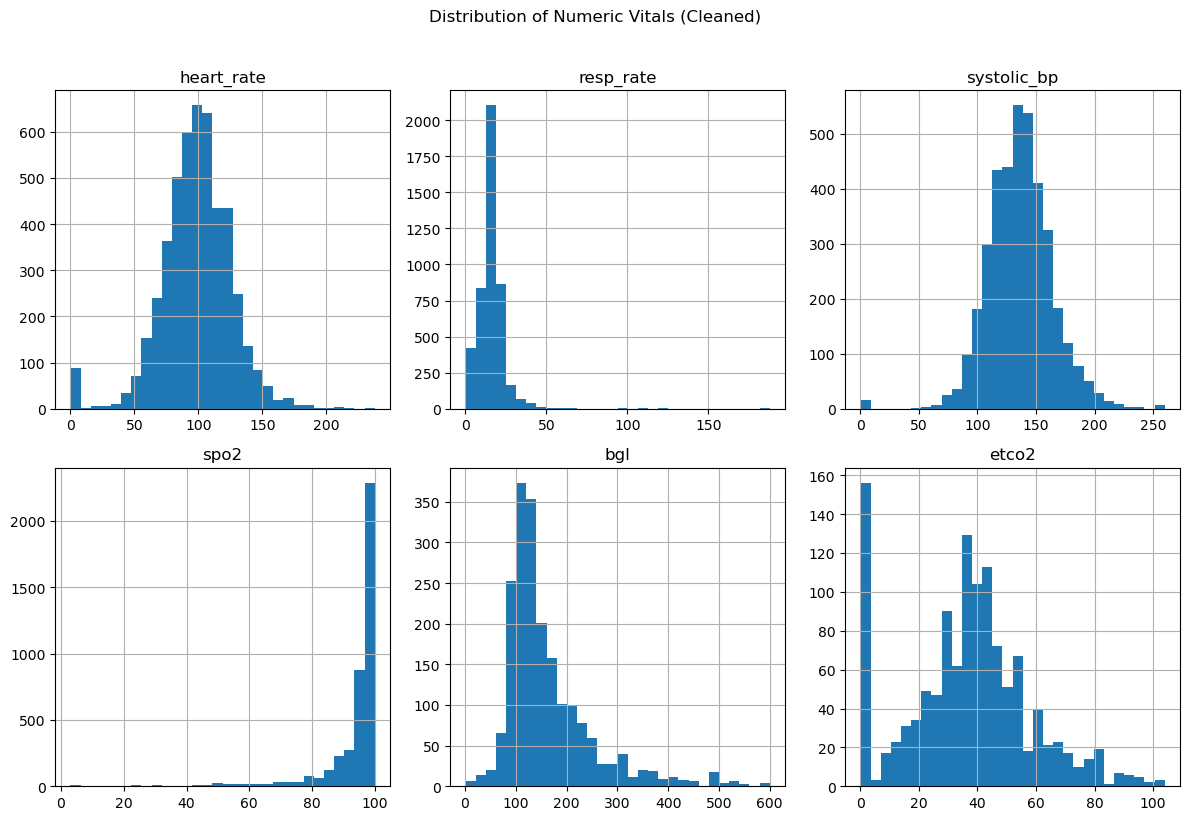

In [150]:
valid_outcomes[num_cols].describe()
valid_outcomes[num_cols].hist(bins=30, figsize=(12, 8), layout=(2, 3))
plt.suptitle('Distribution of Numeric Vitals (Cleaned)', y=1.02)
plt.tight_layout()
plt.show()

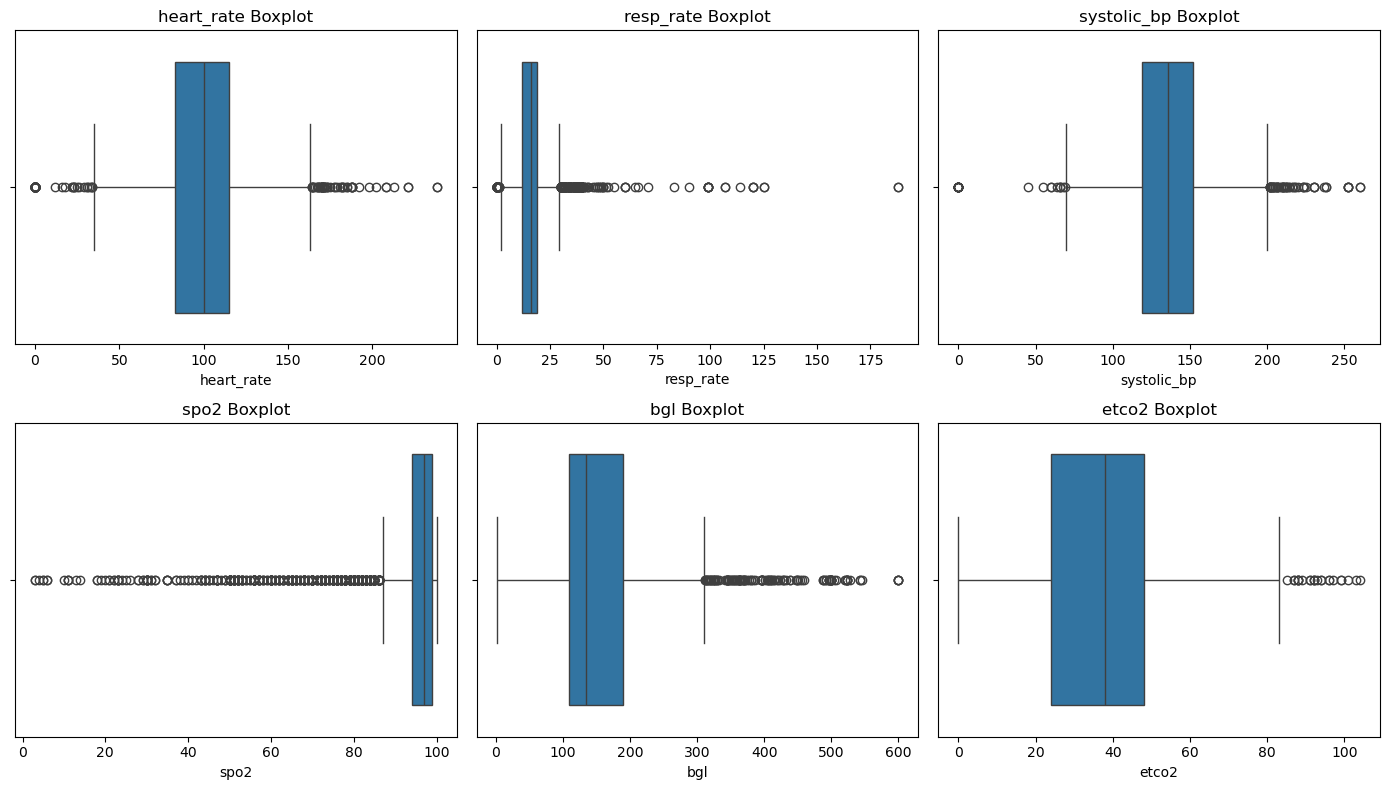

In [151]:
plt.figure(figsize=(14, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=valid_outcomes, x=col)
    plt.title(f'{col} Boxplot')
plt.tight_layout()
plt.show()

In [152]:
# corr = valid_outcomes[num_cols].corr()

# plt.figure(figsize=(8, 6))
# sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Matrix of Vitals')
# plt.tight_layout()
# plt.show()

In [153]:
def plot_vital_by_outcome(df, vital_col, figsize=(12, 6)):
    """
    Creates a boxplot of a vital sign column grouped by eOutcome_01_label.
    """
    plt.figure(figsize=figsize)
    sns.boxplot(data=df, x='eOutcome_01_label', y=vital_col)
    plt.xticks(rotation=90)
    plt.title(f'{vital_col} by ED Disposition Outcome')
    plt.tight_layout()
    plt.show()

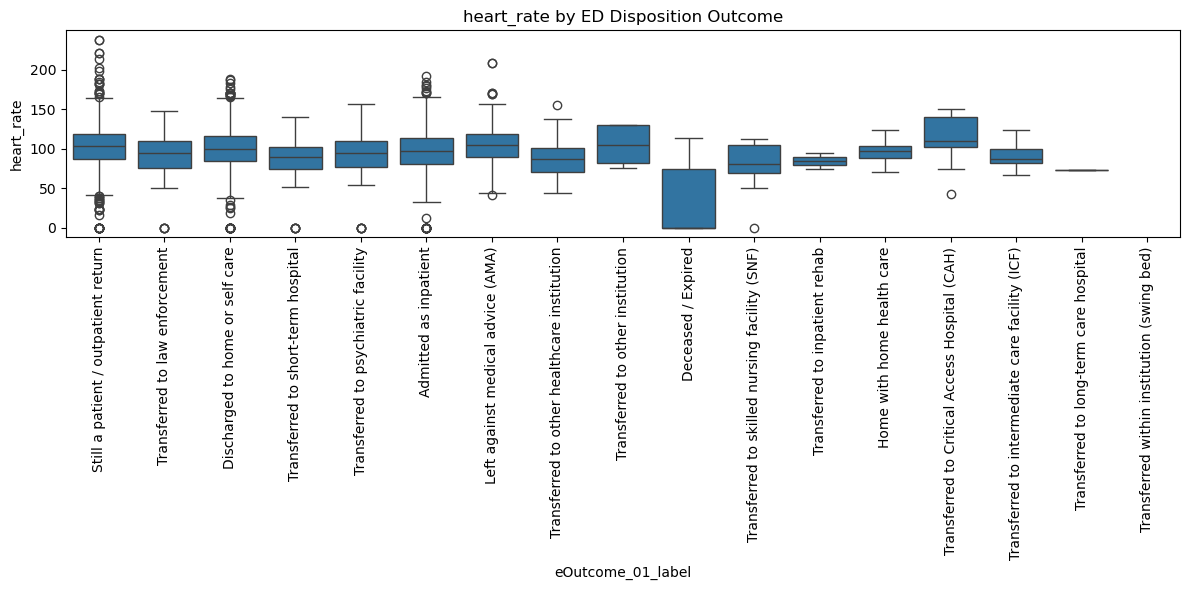

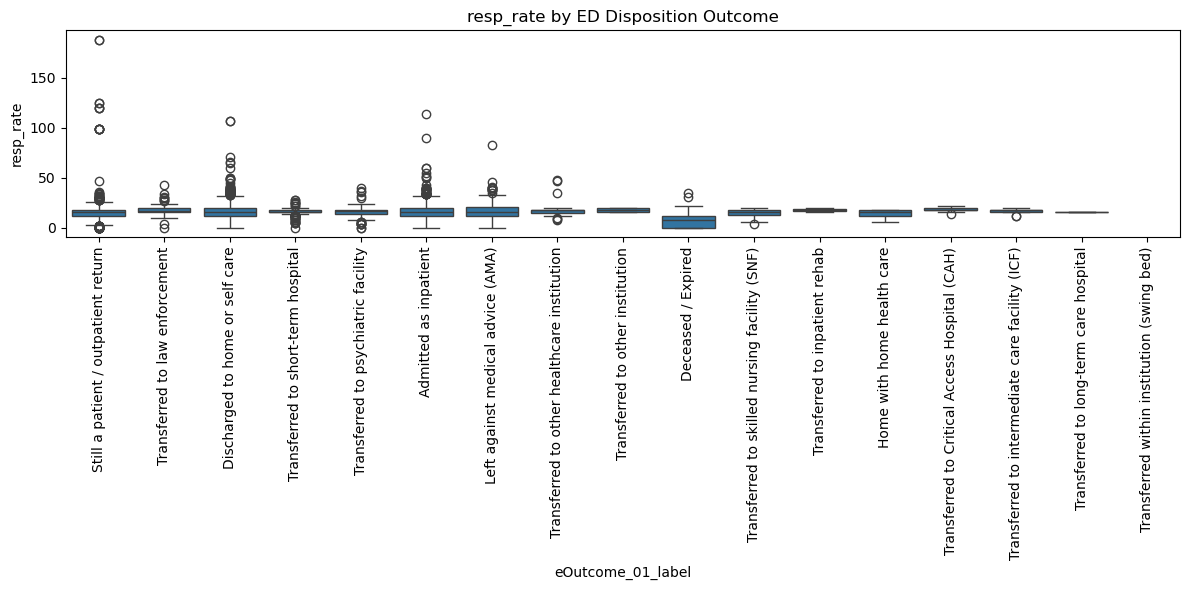

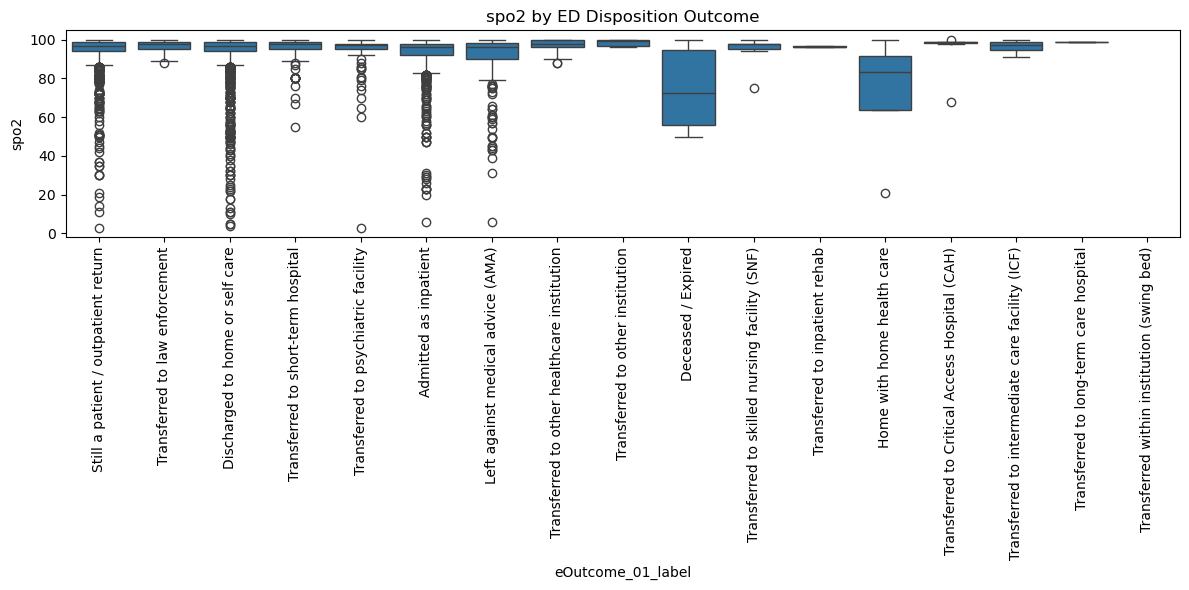

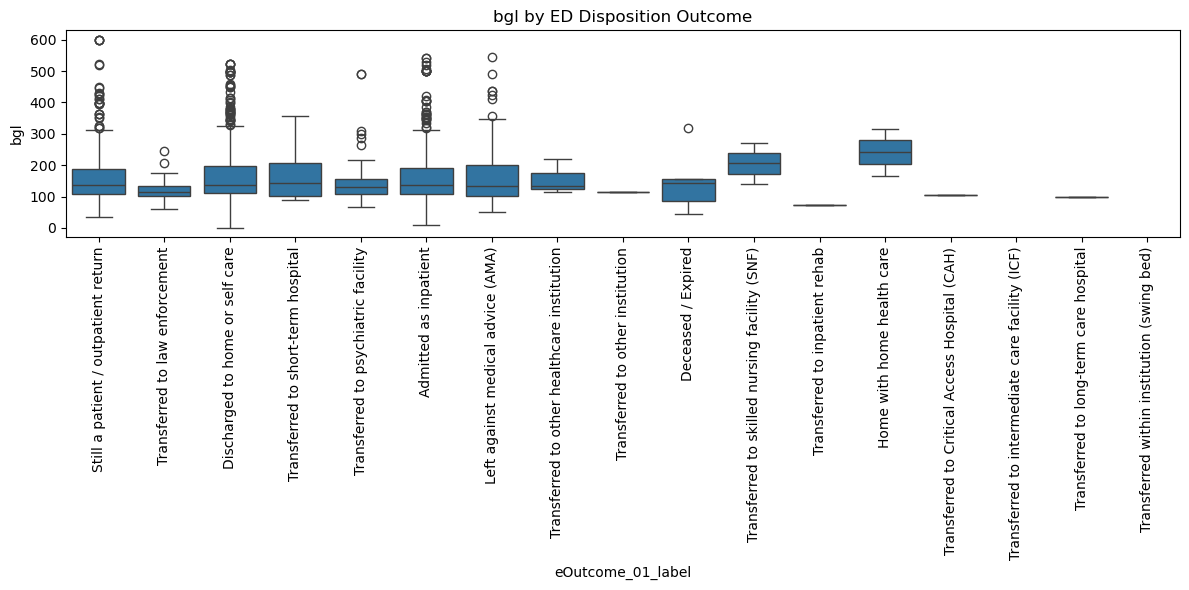

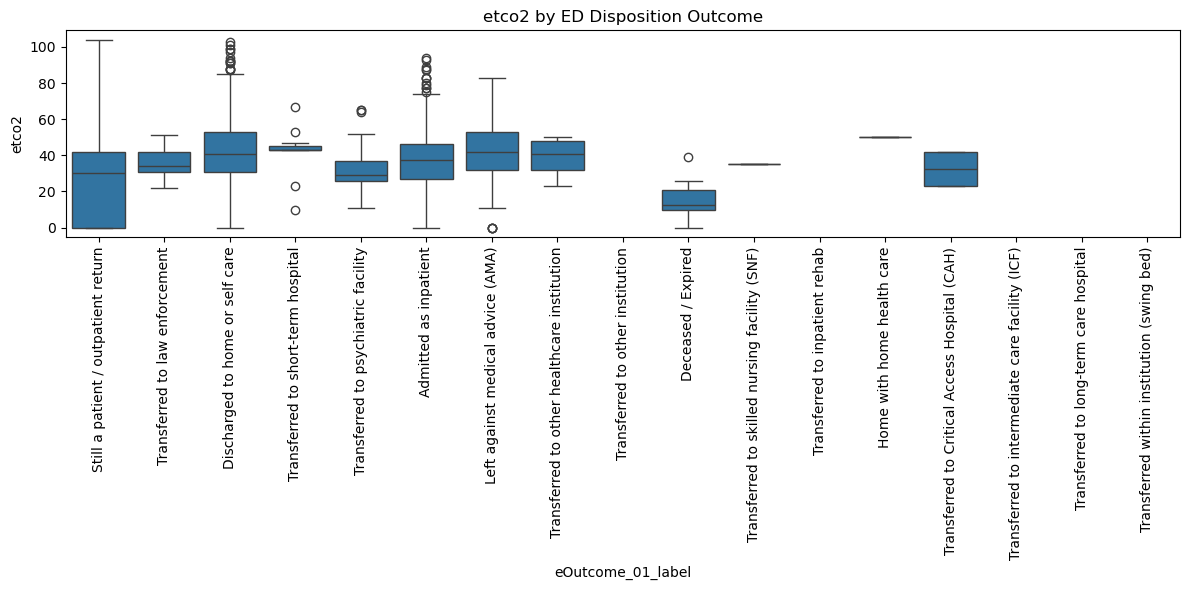

In [154]:
plot_vital_by_outcome(valid_outcomes, 'heart_rate')
plot_vital_by_outcome(valid_outcomes, 'resp_rate')
plot_vital_by_outcome(valid_outcomes, 'spo2')
plot_vital_by_outcome(valid_outcomes, 'bgl')
plot_vital_by_outcome(valid_outcomes, 'etco2')

# Data Prep

In [155]:
class_1 = ['02','03','04','05','06','09','20','30','43','50','51','61','62','63','64','65','66','70']
class_0 = ['01','07','21']

valid_outcomes['target_admit'] = np.where(valid_outcomes['eOutcome_01'].isin(class_1), 1,
                                          np.where(valid_outcomes['eOutcome_01'].isin(class_0), 0, np.nan))

valid_outcomes = valid_outcomes.dropna(subset=['target_admit'])
valid_outcomes['target_admit'] = valid_outcomes['target_admit'].astype(int)

In [156]:
rename_dict = {
    # Dispatch & Arrest
    'eDispatch_01': 'dispatch_complaint',
    'eDispatch_02': 'emd_performed',
    'eArrest_01': 'cardiac_arrest',
    'eArrest_02': 'arrest_etiology',
    'eArrest_05': 'cpr_prior_to_ems',
    'eArrest_07': 'aed_prior_to_ems',
    'eArrest_11': 'first_monitored_arrest_rhythm',
    'eArrest_14': 'arrest_datetime',
    'eArrest_16': 'resuscitation_discontinued_reason',
    'eArrest_18': 'end_of_cardiac_arrest_event',

    # Disposition
    'eDisposition_12': 'incident_patient_disposition',
    'eDisposition_16': 'ems_transport_method',
    'eDisposition_17': 'transport_mode_from_scene',
    'eDisposition_18': 'additional_transport_descriptors',
    'eDisposition_19': 'final_patient_acuity',
    'eDisposition_20': 'reason_for_destination_choice',
    'eDisposition_21': 'destination_type',
    'eDisposition_22': 'hospital_inpatient_destination',
    'eDisposition_23': 'hospital_capability',
    'eDisposition_24': 'destination_team_alert',
    'eDisposition_25': 'destination_team_alert_time',

    # Outcome
    'eOutcome_01': 'ed_disposition',
    'eOutcome_02': 'hospital_disposition',

    # Patient
    'ePatient_15': 'patient_age',
    'ePatient_16': 'patient_age_units',

    # Payment
    'ePayment_01': 'primary_payment_method',
    'ePayment_50': 'cms_service_level',

    # Response
    'eResponse_05': 'service_requested',
    'eResponse_07': 'unit_primary_role',
    'eResponse_08_count': 'crew_members_count',
    'eResponse_08_unique': 'crew_members_unique',
    'eResponse_08_present': 'crew_members_present',
    'eResponse_09_count': 'crew_levels_count',
    'eResponse_09_unique': 'crew_levels_unique',
    'eResponse_09_present': 'crew_levels_present',
    'eResponse_10_count': 'vehicle_type_count',
    'eResponse_10_unique': 'vehicle_type_unique',
    'eResponse_10_present': 'vehicle_type_present',
    'eResponse_11_count': 'dispatch_delay_count',
    'eResponse_11_unique': 'dispatch_delay_unique',
    'eResponse_11_present': 'dispatch_delay_present',
    'eResponse_12_count': 'response_delay_count',
    'eResponse_12_unique': 'response_delay_unique',
    'eResponse_12_present': 'response_delay_present',
    'eResponse_15': 'unit_level_of_care',
    'eResponse_23': 'response_mode_to_scene',
    'eResponse_24': 'additional_response_mode',

    # Scene
    'eScene_01': 'first_unit_on_scene',
    'eScene_06': 'patients_on_scene',
    'eScene_07': 'mass_casualty_incident',
    'eScene_08': 'triage_category_mci',
    'eScene_09': 'incident_location_type',

    # Situation
    'eSituation_01': 'symptom_onset_datetime',
    'eSituation_02': 'possible_injury',
    'eSituation_07': 'chief_complaint_location',
    'eSituation_08': 'chief_complaint_system',
    'eSituation_09': 'primary_symptom',
    'eSituation_11': 'primary_provider_impression',
    'eSituation_12': 'secondary_provider_impressions',
    'eSituation_13': 'initial_acuity',

    # Times
    'eTimes_01': 'psap_call_datetime',
    'eTimes_03': 'unit_notified_datetime',
    'eTimes_05': 'unit_enroute_datetime',
    'eTimes_06': 'unit_arrived_scene_datetime',
    'eTimes_07': 'arrived_at_patient_datetime',
    'eTimes_09': 'unit_left_scene_datetime',
    'eTimes_11': 'arrived_destination_datetime',
    'eTimes_12': 'patient_transfer_datetime',
    'eTimes_13': 'unit_back_in_service_datetime',
}

valid_outcomes.rename(columns=rename_dict, inplace=True)

In [157]:
print(valid_outcomes.columns)

Index(['PcrKey', 'dispatch_complaint', 'emd_performed', 'arrest_datetime',
       'cardiac_arrest', 'arrest_etiology', 'cpr_prior_to_ems',
       'aed_prior_to_ems', 'first_monitored_arrest_rhythm',
       'resuscitation_discontinued_reason', 'end_of_cardiac_arrest_event',
       'incident_patient_disposition', 'final_patient_acuity',
       'ems_transport_method', 'destination_type',
       'hospital_inpatient_destination', 'hospital_capability',
       'ed_disposition', 'hospital_disposition', 'patient_age',
       'patient_age_units', 'primary_payment_method', 'cms_service_level',
       'service_requested', 'unit_primary_role', 'unit_level_of_care',
       'response_mode_to_scene', 'first_unit_on_scene', 'patients_on_scene',
       'mass_casualty_incident', 'triage_category_mci',
       'incident_location_type', 'possible_injury', 'chief_complaint_location',
       'chief_complaint_system', 'initial_acuity', 'symptom_onset_datetime',
       'psap_call_datetime', 'unit_notified_date

In [158]:
drop_cols = [
    # Operational and metadata
    'PcrKey', 'arrest_datetime', 'dispatch_complaint', 'emd_performed', 'psap_call_datetime',
    'unit_level_of_care', 'service_requested', 'unit_primary_role',
    'response_mode_to_scene', 'additional_response_mode',
    'ems_transport_method', 'transport_mode_from_scene', 'additional_transport_descriptors',
    'mass_casualty_incident', 'incident_location_type', 'patients_on_scene', 'triage_category_mci',
    'crew_members_count', 'crew_members_unique', 'crew_members_present',
    'crew_levels_count', 'crew_levels_unique', 'crew_levels_present',
    'vehicle_type_count', 'vehicle_type_unique', 'vehicle_type_present',
    'dispatch_delay_count', 'dispatch_delay_unique', 'dispatch_delay_present',
    'response_delay_count', 'response_delay_unique', 'response_delay_present',
    'ed_disposition', 'hospital_disposition', 'destination_type',
    'hospital_inpatient_destination', 'hospital_capability',
    'reason_for_destination_choice', 'destination_team_alert', 'destination_team_alert_time',
    'symptom_onset_datetime', 'unit_notified_datetime', 'unit_enroute_datetime',
    'unit_arrived_scene_datetime', 'arrived_at_patient_datetime',
    'unit_left_scene_datetime', 'arrived_destination_datetime',
    'patient_transfer_datetime', 'unit_back_in_service_datetime',
    'eOutcome_01_label'
]


modeling_df = valid_outcomes.drop(columns=drop_cols)

In [159]:
print(f"Final dataframe shape: {modeling_df.shape}")

Final dataframe shape: (5677, 50)


In [160]:
modeling_df.info()

# Or a more concise view:
modeling_df.isnull().mean().sort_values(ascending=False).head(20)


<class 'pandas.core.frame.DataFrame'>
Index: 5677 entries, 99 to 297622
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   cardiac_arrest                     5677 non-null   object 
 1   arrest_etiology                    5677 non-null   object 
 2   cpr_prior_to_ems                   5677 non-null   object 
 3   aed_prior_to_ems                   5677 non-null   object 
 4   first_monitored_arrest_rhythm      5677 non-null   object 
 5   resuscitation_discontinued_reason  5677 non-null   object 
 6   end_of_cardiac_arrest_event        5677 non-null   object 
 7   incident_patient_disposition       5677 non-null   object 
 8   final_patient_acuity               5677 non-null   object 
 9   patient_age                        5677 non-null   object 
 10  patient_age_units                  5677 non-null   object 
 11  primary_payment_method             5677 non-null   object 

etco2                    0.782808
bgl                      0.648230
systolic_bp              0.320416
spo2                     0.260349
resp_rate                0.202748
heart_rate               0.149551
assoc_symptom_unique     0.024837
assoc_symptom_count      0.024837
cardiac_arrest           0.000000
barrier_count            0.000000
barrier_present          0.000000
any_med_administered     0.000000
med_count                0.000000
naloxone_administered    0.000000
any_procedure            0.000000
proc_count               0.000000
alcohol_drug_use_flag    0.000000
protocols_used           0.000000
protocol_count           0.000000
arrest_witnessed_flag    0.000000
dtype: float64

In [161]:
# Drop etco2
modeling_df.drop(columns='etco2', inplace=True)

# Add missingness indicators for vitals
for col in ['bgl', 'systolic_bp', 'spo2', 'resp_rate', 'heart_rate']:
    modeling_df[f'{col}_missing'] = modeling_df[col].isna().astype(int)

# Median imputation
for col in ['bgl', 'systolic_bp', 'spo2', 'resp_rate', 'heart_rate']:
    modeling_df[col] = modeling_df[col].fillna(modeling_df[col].median())

In [162]:
modeling_df.info()

# Or a more concise view:
modeling_df.isnull().mean().sort_values(ascending=False).head(20)


<class 'pandas.core.frame.DataFrame'>
Index: 5677 entries, 99 to 297622
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   cardiac_arrest                     5677 non-null   object 
 1   arrest_etiology                    5677 non-null   object 
 2   cpr_prior_to_ems                   5677 non-null   object 
 3   aed_prior_to_ems                   5677 non-null   object 
 4   first_monitored_arrest_rhythm      5677 non-null   object 
 5   resuscitation_discontinued_reason  5677 non-null   object 
 6   end_of_cardiac_arrest_event        5677 non-null   object 
 7   incident_patient_disposition       5677 non-null   object 
 8   final_patient_acuity               5677 non-null   object 
 9   patient_age                        5677 non-null   object 
 10  patient_age_units                  5677 non-null   object 
 11  primary_payment_method             5677 non-null   object 

assoc_symptom_unique     0.024837
assoc_symptom_count      0.024837
cardiac_arrest           0.000000
barrier_present          0.000000
resp_rate                0.000000
systolic_bp              0.000000
spo2                     0.000000
bgl                      0.000000
any_med_administered     0.000000
med_count                0.000000
naloxone_administered    0.000000
any_procedure            0.000000
proc_count               0.000000
alcohol_drug_use_flag    0.000000
protocols_used           0.000000
protocol_count           0.000000
arrest_witnessed_flag    0.000000
resuscitation_flag       0.000000
cpr_provided_flag        0.000000
rosc_flag                0.000000
dtype: float64

In [163]:
modeling_df.select_dtypes(include='object').nunique().sort_values(ascending=False)

secondary_provider_impressions       234
primary_symptom                      183
primary_provider_impression          180
protocols_used                       108
patient_age                           90
incident_patient_disposition          14
chief_complaint_system                12
primary_payment_method                12
chief_complaint_location              11
cms_service_level                      9
end_of_cardiac_arrest_event            8
first_monitored_arrest_rhythm          8
final_patient_acuity                   6
arrest_etiology                        6
resuscitation_discontinued_reason      6
initial_acuity                         6
patient_age_units                      5
possible_injury                        5
aed_prior_to_ems                       5
cpr_prior_to_ems                       5
cardiac_arrest                         5
first_unit_on_scene                    4
dtype: int64

In [164]:
modeling_df.dtypes.value_counts()

int64      25
object     22
float64     7
Name: count, dtype: int64

In [165]:
high_card_cols = [
    'secondary_provider_impressions',
    'primary_symptom',
    'primary_provider_impression',
    'protocols_used'
]

for col in high_card_cols:
    print(f"\n--- {col} ---")
    print(modeling_df[col].value_counts(dropna=False).head(15))
    print(f"Unique values: {modeling_df[col].nunique()} | Missing: {modeling_df[col].isna().sum()}")


--- secondary_provider_impressions ---
secondary_provider_impressions
7701003     1225
7701001     1058
F11          649
R41.82       357
nan          257
Z00.00       120
T40.2X1A     109
T50.994A      88
F11.9         87
R53.1         87
T40.4         76
F99           72
R06.81        65
T40.2X1       58
F11.10        58
Name: count, dtype: int64
Unique values: 234 | Missing: 0

--- primary_symptom ---
primary_symptom
R41.82     1585
R40.20      742
T40.60      321
R46.4       212
nan         196
R42         158
R53.1       146
R06.81      145
R09.2       132
7701001     111
F15.129     111
R46.2       102
R52          70
7701003      64
R45.851      58
Name: count, dtype: int64
Unique values: 183 | Missing: 0

--- primary_provider_impression ---
primary_provider_impression
F11         2090
T40.2X1A     556
F11.10       333
nan          333
R41.82       320
T40.1        181
T40.1X4A     147
T40.4        136
F11.9        106
F11.1         79
I46.9         66
T40.601       66
T40.691 

In [166]:
# Handle high cardinality features

# Drop low-value column
modeling_df = modeling_df.drop(columns='secondary_provider_impressions')

# Clean and simplify ICD-10 fields
high_card_categoricals = {
    'primary_symptom': 20,
    'primary_provider_impression': 20
}

for col, top_n in high_card_categoricals.items():
    # Replace placeholder values
    modeling_df[col] = modeling_df[col].replace(['7701001', '7701003', 'nan'], np.nan)
    
    # Group infrequent categories into "Other"
    top_vals = modeling_df[col].value_counts().nlargest(top_n).index
    modeling_df[col] = modeling_df[col].where(modeling_df[col].isin(top_vals), 'Other')

# Create binary flags for top protocol codes
# clean and split protocols
clean_protocols = modeling_df['protocols_used'].replace(['7701001', '7701003'], np.nan)
split_protocols = clean_protocols.dropna().apply(lambda x: x.split(','))

# find most common protocol codes
all_protocols = pd.Series(code for sublist in split_protocols for code in sublist)
top_protocols = all_protocols.value_counts().nlargest(5).index

# create binary flags
for code in top_protocols:
    modeling_df[f'protocol_{code}'] = modeling_df['protocols_used'].apply(
        lambda x: int(code in str(x).split(',')) if pd.notnull(x) else 0
    )

# Drop raw protocols_used
modeling_df = modeling_df.drop(columns='protocols_used')

In [167]:
# Handle medium cardinality features

# Columns to group
med_card_cols = [
    'incident_patient_disposition',
    'chief_complaint_system',
    'primary_payment_method',
    'chief_complaint_location',
    'cms_service_level'
]

# How many categories to retain
top_n = 10

for col in med_card_cols:
    # Standardize missing values
    modeling_df[col] = modeling_df[col].replace(['7701001', '7701003', 'nan'], np.nan)
    
    # Group infrequent values
    top_vals = modeling_df[col].value_counts().nlargest(top_n).index
    modeling_df[col] = modeling_df[col].where(modeling_df[col].isin(top_vals), 'Other')

In [169]:
# Handle ordinal and lower cardinality features

# --- Part 1: Clean and Encode Ordinal + Low-Cardinality Categoricals ---

# Replace junk codes
low_card_cols = [
    'final_patient_acuity', 'initial_acuity',
    'resuscitation_discontinued_reason', 'arrest_etiology',
    'first_monitored_arrest_rhythm', 'patient_age_units'
]
for col in low_card_cols:
    modeling_df[col] = modeling_df[col].replace(['7701001', '7701003', 'nan', 'Unknown'], np.nan)

# Ordinal encoding for acuity
acuity_map = {
    '1': 1, '2': 2, '3': 3, '4': 4, '5': 5,
    'Critical': 1, 'Emergent': 2, 'Urgent': 3,
    'Non-Urgent': 4, 'Low': 5
}
for col in ['final_patient_acuity', 'initial_acuity']:
    modeling_df[col] = modeling_df[col].map(acuity_map)

# Map patient_age_units if needed
age_unit_map = {'1': 'Years', '2': 'Months', '3': 'Days', '4': 'Hours', '5': 'Minutes'}
modeling_df['patient_age_units'] = modeling_df['patient_age_units'].replace(age_unit_map)

# --- Part 2: Clean and Convert Binary Flags Safely ---

binary_cols = [
    'cardiac_arrest', 'aed_prior_to_ems', 'cpr_prior_to_ems',
    'possible_injury', 'barrier_present', 'any_med_administered',
    'naloxone_administered', 'any_procedure', 'alcohol_drug_use_flag',
    'arrest_witnessed_flag', 'resuscitation_flag',
    'cpr_provided_flag', 'rosc_flag'
]

invalid_vals = ['Unknown', '7701001', '7701003', 'nan', '', None]

for col in binary_cols:
    # Replace junk
    modeling_df[col] = modeling_df[col].replace(invalid_vals, np.nan)
    
    # Map expected binary values
    modeling_df[col] = modeling_df[col].replace({'Yes': 1, 'No': 0, 'True': 1, 'False': 0})
    
    # Coerce safely to numeric
    modeling_df[col] = pd.to_numeric(modeling_df[col], errors='coerce')

In [170]:
modeling_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5677 entries, 99 to 297622
Data columns (total 57 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   cardiac_arrest                     5677 non-null   float64
 1   arrest_etiology                    132 non-null    object 
 2   cpr_prior_to_ems                   110 non-null    float64
 3   aed_prior_to_ems                   5677 non-null   float64
 4   first_monitored_arrest_rhythm      106 non-null    object 
 5   resuscitation_discontinued_reason  105 non-null    object 
 6   end_of_cardiac_arrest_event        5677 non-null   object 
 7   incident_patient_disposition       5677 non-null   object 
 8   final_patient_acuity               0 non-null      float64
 9   patient_age                        5677 non-null   object 
 10  patient_age_units                  5668 non-null   object 
 11  primary_payment_method             5677 non-null   object 

In [171]:
modeling_df.select_dtypes(include='object').nunique().sort_values(ascending=False)

patient_age                          90
primary_symptom                      21
primary_provider_impression          21
incident_patient_disposition         11
primary_payment_method               11
chief_complaint_system               11
chief_complaint_location             10
end_of_cardiac_arrest_event           8
cms_service_level                     8
first_monitored_arrest_rhythm         6
arrest_etiology                       4
resuscitation_discontinued_reason     4
patient_age_units                     4
first_unit_on_scene                   4
dtype: int64

In [172]:
modeling_df.isnull().mean().sort_values(ascending=False).head(20)

initial_acuity                       1.000000
final_patient_acuity                 1.000000
resuscitation_discontinued_reason    0.981504
first_monitored_arrest_rhythm        0.981328
cpr_prior_to_ems                     0.980624
arrest_etiology                      0.976748
assoc_symptom_unique                 0.024837
assoc_symptom_count                  0.024837
possible_injury                      0.013211
patient_age_units                    0.001585
race_count                           0.000000
protocol_count                       0.000000
arrest_witnessed_flag                0.000000
resuscitation_flag                   0.000000
alcohol_drug_use_flag                0.000000
cpr_provided_flag                    0.000000
rosc_flag                            0.000000
proc_count                           0.000000
dest_rhythm_count                    0.000000
any_procedure                        0.000000
dtype: float64

In [173]:
modeling_df['target_admit'].value_counts(normalize=True)

target_admit
1    0.534437
0    0.465563
Name: proportion, dtype: float64

In [175]:
# Highly null features after mapping need to be removed

to_drop = ['final_patient_acuity',
           'initial_acuity',
           'resuscitation_discontinued_reason',
           'first_monitored_arrest_rhythm',
           'cpr_prior_to_ems',
           'arrest_etiology'
]

modeling_df.drop(columns=to_drop, inplace=True)

In [176]:
print(modeling_df['patient_age'].value_counts().head(20))


patient_age
30    214
31    183
34    170
35    168
38    160
37    156
32    153
36    152
40    151
27    138
33    137
42    133
25    130
29    129
39    125
28    120
24    116
50    116
41    107
45    107
Name: count, dtype: int64


In [177]:
print(modeling_df['patient_age_units'].value_counts(dropna=False))


patient_age_units
2516009    5659
NaN           9
2516003       3
2516001       3
2516007       3
Name: count, dtype: int64


In [178]:
# Map of unit codes to multipliers for months
to_months_map = {
    '2516001': 1 / 30.44,             # Days
    '2516003': 1 / (30.44 * 24),      # Hours
    '2516005': 1 / (30.44 * 24 * 60), # Minutes
    '2516007': 1,                     # Months
    '2516009': 12                     # Years
}

# Function to convert age to months
def convert_to_months(row):
    try:
        age = float(row['patient_age'])
    except:
        return np.nan
    factor = to_months_map.get(str(row['patient_age_units']), np.nan)
    return age * factor if factor is not None else np.nan

# Apply conversion
modeling_df['age_in_months'] = modeling_df.apply(convert_to_months, axis=1)

# Drop original columns
modeling_df.drop(columns=['patient_age', 'patient_age_units'], inplace=True)

In [179]:
# Define bins and labels
age_bins = [-np.inf, 1, 12, 36, 60, 132, 216, 300, 600, 780, np.inf]
age_labels = [
    'Neonate', 'Infant', 'Toddler', 'Preschool', 'School Age',
    'Adolescent', 'Young Adult', 'Adult', 'Middle Age', 'Older Adult'
]

# Create binned column
modeling_df['age_group'] = pd.cut(
    modeling_df['age_in_months'],
    bins=age_bins,
    labels=age_labels,
    right=False
)

# Modeling

In [180]:
# Separate target and features
X = modeling_df.drop(columns=['target_admit'])
y = modeling_df['target_admit']

# One-hot encode categorical features (drop_first to avoid multicollinearity)
X_encoded = pd.get_dummies(X, drop_first=True)

# Train/test split (80/20) with stratification to preserve target distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

In [185]:
# Impute missing values (mean for numeric, most_frequent works okay with one-hot cols)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Train baseline logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = logreg.predict(X_test_scaled)
y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

print("=== Logistic Regression Baseline ===")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

=== Logistic Regression Baseline ===
              precision    recall  f1-score   support

           0       0.73      0.81      0.77       529
           1       0.82      0.74      0.78       607

    accuracy                           0.77      1136
   macro avg       0.77      0.77      0.77      1136
weighted avg       0.78      0.77      0.77      1136

ROC AUC: 0.8528


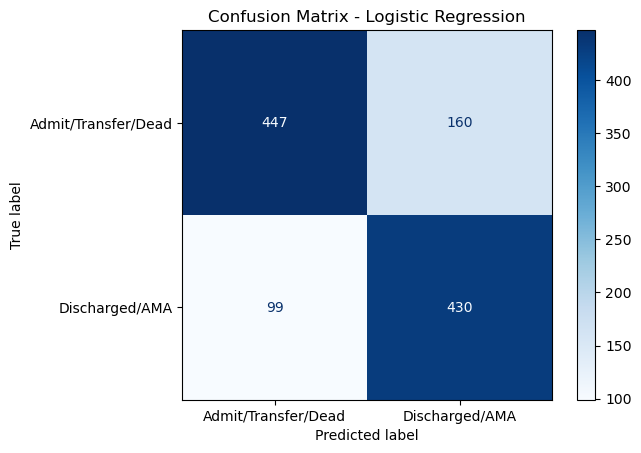

In [188]:
# Generate predictions
y_pred = logreg.predict(X_test_scaled)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])  # Put class 1 first for clarity

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Admit/Transfer/Dead", "Discharged/AMA"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.show()

In [197]:
# Now a XGBoost model

# Initialize and fit XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("=== XGBoost Classifier ===")
print(classification_report(y_test, y_pred, target_names=["Discharged/AMA", "Admit/Transfer/Dead"]))
print("ROC AUC:", roc_auc_score(y_test, y_prob).round(4))

=== XGBoost Classifier ===
                     precision    recall  f1-score   support

     Discharged/AMA       0.78      0.86      0.82       529
Admit/Transfer/Dead       0.86      0.79      0.82       607

           accuracy                           0.82      1136
          macro avg       0.82      0.82      0.82      1136
       weighted avg       0.82      0.82      0.82      1136

ROC AUC: 0.9063


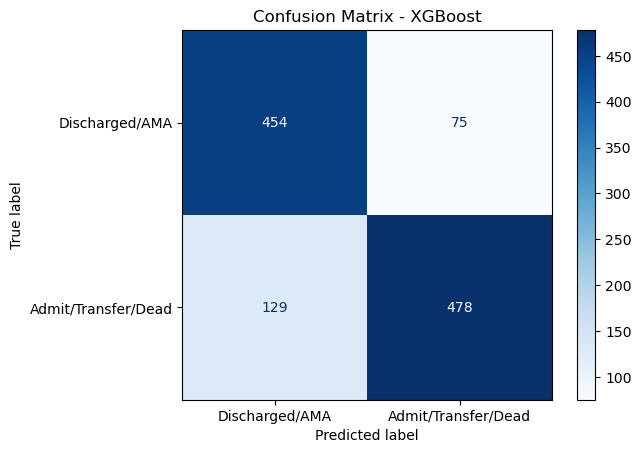

In [198]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Discharged/AMA", "Admit/Transfer/Dead"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.show()

In [200]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_lambda': [0.1, 1.0, 10],
    'reg_alpha': [0, 0.1, 1.0]
}

# Define model
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Set up randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=50,
    scoring=make_scorer(recall_score),  # maximize recall
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run search
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           num_parallel_tree=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 1.0],
                                        'reg_lambda': [0.1, 1.0, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42,
                   scoring=make_scorer(recall_score, response_method='predict'),
                   verbose=1)

                     precision    recall  f1-score   support

     Discharged/AMA       0.80      0.86      0.83       529
Admit/Transfer/Dead       0.87      0.81      0.84       607

           accuracy                           0.83      1136
          macro avg       0.83      0.84      0.83      1136
       weighted avg       0.84      0.83      0.83      1136

ROC AUC: 0.9104991233342571


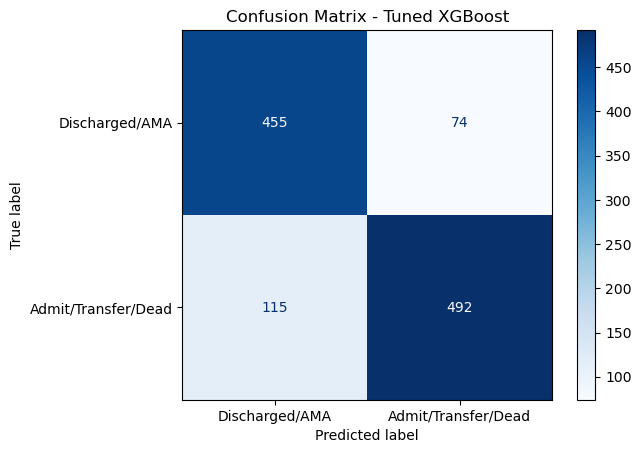

In [202]:
best_xgb = random_search.best_estimator_

y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, target_names=["Discharged/AMA", "Admit/Transfer/Dead"]))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(
    best_xgb, 
    X_test, 
    y_test, 
    display_labels=["Discharged/AMA", "Admit/Transfer/Dead"], 
    cmap='Blues'
)
plt.title("Confusion Matrix - Tuned XGBoost")
plt.show()